<a href="https://colab.research.google.com/github/umiSirya/MachineLearning_2/blob/main/Plant_Village.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import os
import keras
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from sklearn.model_selection import train_test_split

# **Loading the Dataset**

In [ ]:
!kaggle datasets download -d abdallahalidev/plantvillage-dataset


Dataset URL: https://www.kaggle.com/datasets/abdallahalidev/plantvillage-dataset
License(s): CC-BY-NC-SA-4.0
100% 2.04G/2.04G [01:22<00:00, 24.7MB/s]
100% 2.04G/2.04G [01:22<00:00, 26.5MB/s]


In [ ]:
#Unzip the datastet
!unzip -q plantvillage-dataset.zip

In [ ]:
#List of foloders
!ls plantvillage\ dataset

color  grayscale  segmented


In [ ]:
import os
import random
from PIL import Image
import matplotlib.pyplot as plt

def view_random_image(dataset_path, target_class='color'):
    class_path = os.path.join(dataset_path, target_class)

    all_images = []
    for root, dirs, files in os.walk(class_path):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
                all_images.append(os.path.join(root, file))

    if not all_images:
        raise FileNotFoundError(f"No image files found in {class_path}")

    random_image_path = random.choice(all_images)

    img = Image.open(random_image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Random Image from {target_class}")
    plt.show()


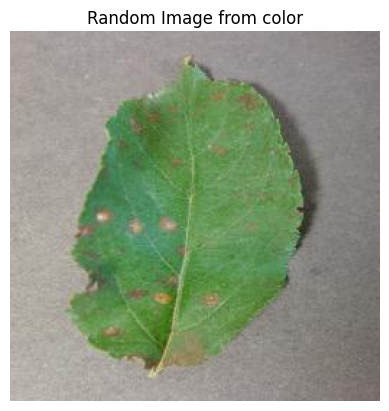

In [ ]:
#View a random image form the dataset
img = view_random_image('/content/plantvillage dataset', target_class='color')

# **Pre processing**

In [ ]:
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Define dataset base path and parameters
base_path = "/content/plantvillage dataset"
folders = ["color", "grayscale", "segmented"]
target_size = (128, 128)  # Resize images to 128x128
batch_size = 32
num_classes = 38  # Number of classes in the PlantVillage dataset
AUTOTUNE = tf.data.AUTOTUNE

# Function to load and preprocess datasets
def load_and_preprocess(folder_path, color_mode="rgb", num_classes=38):
    dataset = tf.keras.utils.image_dataset_from_directory(
        folder_path,
        image_size=target_size,
        batch_size=batch_size,
        color_mode=color_mode
    )
    # Normalize images and one-hot encode labels
    return dataset.map(lambda x, y: (x / 255.0, tf.one_hot(y, num_classes)))

# Load datasets for color, grayscale, and segmented folders
color_dataset = load_and_preprocess(os.path.join(base_path, folders[0]), color_mode="rgb", num_classes=num_classes)
grayscale_dataset = load_and_preprocess(os.path.join(base_path, folders[1]), color_mode="grayscale", num_classes=num_classes)
segmented_dataset = load_and_preprocess(os.path.join(base_path, folders[2]), color_mode="rgb", num_classes=num_classes)

# Combine datasets
all_datasets = color_dataset.concatenate(grayscale_dataset).concatenate(segmented_dataset)

# Shuffle and split datasets into training, validation, and test sets
train_size = 0.7
val_size = 0.15
test_size = 0.15

def split_dataset(dataset, train_frac, val_frac):
    dataset_size = sum(1 for _ in dataset)  # Total number of batches
    train_batches = int(dataset_size * train_frac)
    val_batches = int(dataset_size * val_frac)

    train_ds = dataset.take(train_batches)
    val_ds = dataset.skip(train_batches).take(val_batches)
    test_ds = dataset.skip(train_batches + val_batches)

    return train_ds, val_ds, test_ds

train_dataset, val_dataset, test_dataset = split_dataset(all_datasets, train_size, val_size)

# Limit the training set to 500 images
train_dataset = train_dataset.take(500 // batch_size)  # Ensure we take 500 images

# Add prefetching for performance
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

# Print dataset information
print(f"Training batches: {sum(1 for _ in train_dataset)}")
print(f"Validation batches: {sum(1 for _ in val_dataset)}")
print(f"Test batches: {sum(1 for _ in test_dataset)}")


Found 54305 files belonging to 38 classes.
Found 54305 files belonging to 38 classes.
Found 54306 files belonging to 38 classes.
Training batches: 15
Validation batches: 764
Test batches: 765


**CNN Model**

In [ ]:
from tensorflow.keras import layers, models

# Build the CNN model
model = models.Sequential()

In [ ]:
# Add convolutional and pooling layers
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))  # Input shape: (128, 128, 3)
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Flatten the feature maps and add dense layers
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(38, activation='softmax')) # 38 classes in the PlantVillage dataset

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
# Train the model
try:
    history = model.fit(
        train_dataset,
        epochs=20,
        validation_data=val_dataset
    )
except Exception as e:
    print(f"Error training the model: {e}")

Epoch 1/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 430s 30s/step - accuracy: 0.1258 - loss: 3.4903 - val_accuracy: 0.1583 - val_loss: 3.3356
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 433s 31s/step - accuracy: 0.2064 - loss: 3.1205 - val_accuracy: 0.1450 - val_loss: 3.4013
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 428s 30s/step - accuracy: 0.2718 - loss: 2.7976 - val_accuracy: 0.0292 - val_loss: 4.7727
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 433s 31s/step - accuracy: 0.3805 - loss: 2.3006 - val_accuracy: 0.0254 - val_loss: 8.1403
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 432s 31s/step - accuracy: 0.5013 - loss: 1.8952 - val_accuracy: 0.0354 - val_loss: 10.2977
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 429s 31s/step - accuracy: 0.6281 - loss: 1.4043 - val_accuracy: 0.0651 - val_loss: 9.8646
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 450s 31s/step - accuracy: 0.7204 - loss: 1.0228 - val_accuracy: 0.0577 - val_loss: 9.9511
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 471s 33s/step - accuracy: 0.7278 - loss: 0.9043 - val_accuracy: 0

# **Model Evaluation**

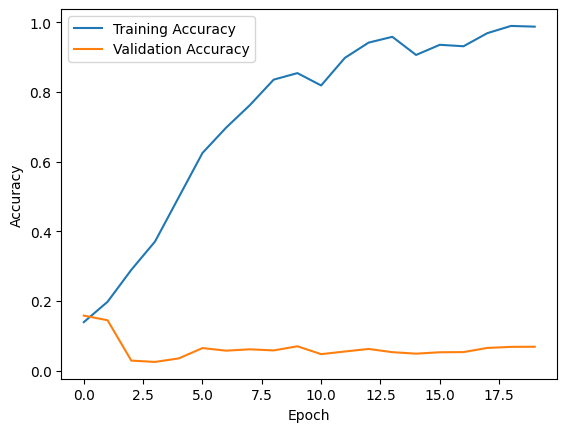

In [ ]:
#Evalauting the model using a graph for accuracy
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

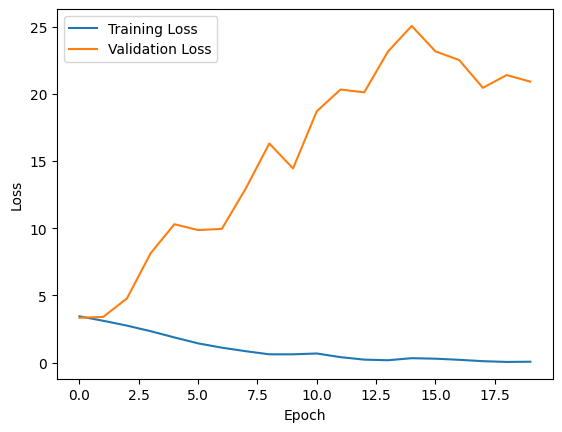

In [ ]:
#Evalauting the model using a graph for loss
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# **Hyperparameter tunning with Randomized Search**

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import ParameterSampler

# Define a function to create the CNN model
def create_model(conv_filters=32, dense_units=128, kernel_size=(3, 3), learning_rate=0.001):
    model = Sequential()
    model.add(Conv2D(conv_filters, kernel_size, activation='relu', input_shape=(128, 128, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(conv_filters * 2, kernel_size, activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(conv_filters * 4, kernel_size, activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(dense_units, activation='relu'))
    model.add(Dense(38, activation='softmax'))  # 4 classes
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Define the hyperparameter grid
param_grid = {
    'conv_filters': [32, 64],
    'dense_units': [128, 256],
    'kernel_size': [(3, 3), (5, 5)],
    'learning_rate': [0.001, 0.0001],
    'batch_size': [16, 32],
    'epochs': [10, 20]
}

# Manual random search function
def random_search(train_data, test_data, param_grid, n_iter=10):
    param_list = list(ParameterSampler(param_grid, n_iter=n_iter))
    best_score = -np.inf
    best_params = None

    for params in param_list:
        print(f"Testing parameters: {params}")

        # Create the model with current parameters
        model = create_model(conv_filters=params['conv_filters'],
                             dense_units=params['dense_units'],
                             kernel_size=params['kernel_size'],
                             learning_rate=params['learning_rate'])

        # Train the model
        early_stopping = EarlyStopping(monitor='val_loss', patience=3)
        history = model.fit(
            train_data,
            validation_data=test_data,
            batch_size=params['batch_size'],
            epochs=params['epochs'],
            callbacks=[early_stopping],
            verbose=0
        )

        # Get validation accuracy
        val_accuracy = history.history['val_accuracy'][-1]
        print(f"Validation Accuracy: {val_accuracy:.4f}")

        # Update the best parameters if the current accuracy is higher
        if val_accuracy > best_score:
            best_score = val_accuracy
            best_params = params

    return best_params, best_score

# Hyperparameter tuning using random search
best_params, best_score = random_search(train_dataset, test_dataset, param_grid, n_iter=10)

# Print the best parameters and score
print("Best Parameters:", best_params)
print("Best Validation Accuracy:", best_score)


Testing parameters: {'learning_rate': 0.001, 'kernel_size': (3, 3), 'epochs': 10, 'dense_units': 128, 'conv_filters': 32, 'batch_size': 32}
Validation Accuracy: 0.0223
Testing parameters: {'learning_rate': 0.0001, 'kernel_size': (5, 5), 'epochs': 10, 'dense_units': 256, 'conv_filters': 64, 'batch_size': 16}
